OVERVIEW:


Feasibility study on “Transforming Singapore Food & Nutrition using Machine Learning" commissioned by "FOOD&AI PTE LTD"

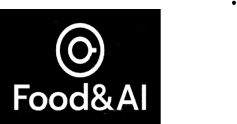


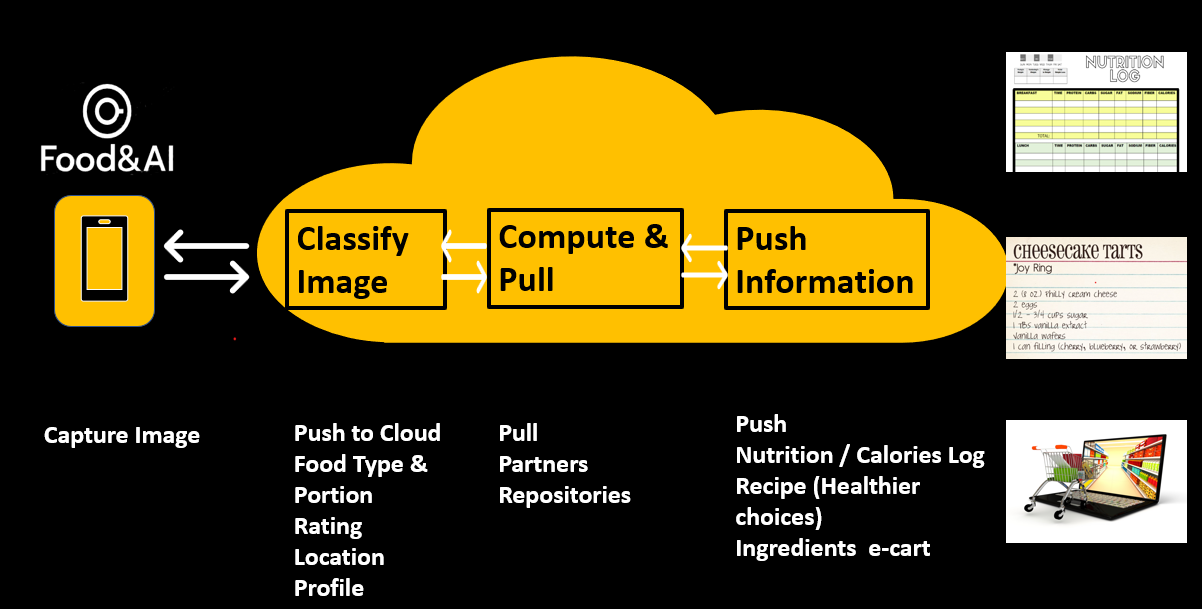

There are 2 objectives for this feasibility study:

Firstly, Image Classification for 9 classes of food type with a target accuracy of at least 85%

Secondly, Recommend suitable Machine Learning Model to be used in actual deployment

Implementation: We will use Deep Learning on several models (base and pre-trained) for this study.

The classes are:

a. Ayam Goreng  b. Ayam Pop c. Daging Rendang

d. Dendeng Batoko e. Gulai Ikan f.Gulai Tambusu

g Gulai Tunjang h. Telur Balado i. Telur Dadar


Dataset is taken from Kaggle: https://www.kaggle.com/datasets/faldoae/padangfood

This dataset has 993 images and will be divided into segments for Train, Validation and Test. 

Image Augmentation is used to increase the dataset.



# 1. Import Library

In [75]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import layers
from keras.layers import Flatten
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout, Activation

from keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3


from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten

# 2. Splitting Directory

In [76]:
!mkdir datasplit

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘datasplit’: File exists


In [77]:
dataraw = '../input/padangfood/dataset_padang_food'
datasplit = './datasplit'

In [78]:
!pip install split-folders 
import splitfolders
splitfolders.ratio(dataraw, output=datasplit, seed=1337, ratio=(.7,.2,.1),group_prefix=None)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Copying files: 993 files [00:02, 348.83 files/s]


In [79]:
test_dir = "./datasplit/test"
train_dir = "./datasplit/train"
val_dir = "./datasplit/val"

In [80]:
print(type(test_dir))

<class 'str'>


# 3. Generate Train and Test Dataset

In [10]:
#GENERATE DATASET FOR TRAINING

train_ds = image_dataset_from_directory(
    directory=train_dir,
    class_names=['ayam_goreng', 'ayam_pop', 'daging_rendang', 'dendeng_batokok', 'gulai_ikan', 'gulai_tambusu', 'gulai_tunjang', 'telur_balado', 'telur_dadar'],
    batch_size=32,
    image_size=(224, 224),
    seed=42, 
    shuffle=True,

)

Found 691 files belonging to 9 classes.


In [12]:
#GENERATE DATASET FOR TESTING

test_ds = image_dataset_from_directory(
    directory=test_dir,
    class_names=['ayam_goreng', 'ayam_pop', 'daging_rendang', 'dendeng_batokok', 'gulai_ikan', 'gulai_tambusu', 'gulai_tunjang', 'telur_balado', 'telur_dadar'],
    batch_size=32,
    image_size=(224, 224),
    seed=42, 
    shuffle=True,

)

Found 108 files belonging to 9 classes.


# 4. Sample review of Train and Test Dataset

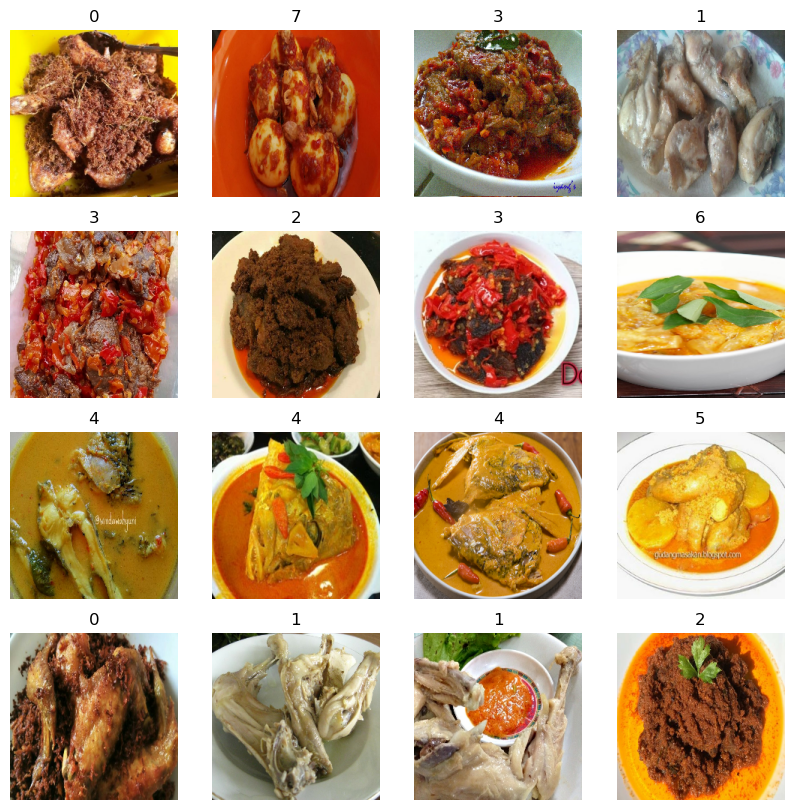

In [13]:
# RANDOM REVIEW OF TRAIN_DS SAMPLES

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(images[i].numpy().astype('uint8'))
        ax.set_title(labels[i].numpy().astype('uint8')  )
        ax.axis('off')
plt.show()


# .numpy() method converts a tensor object into an numpy.ndarray object. 
# This implicitly means that the converted tensor will be now processed on the CPU.

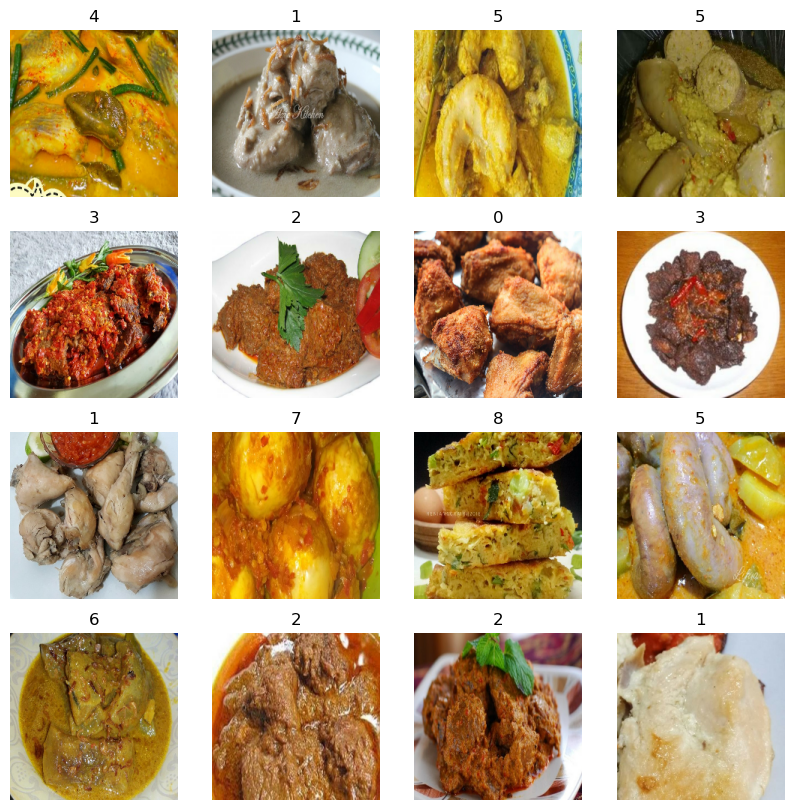

In [14]:
# RANDOM REVIEW OF TEST_DS SAMPLES

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(images[i].numpy().astype('uint8'))
        ax.set_title(labels[i].numpy().astype('uint8')  )
        ax.axis('off')
plt.show()


# .numpy() method converts a tensor object into an numpy.ndarray object. 
# This implicitly means that the converted tensor will be now processed on the CPU.

In [28]:
os.listdir()

['datasplit', '.virtual_documents', '__notebook_source__.ipynb']

In [29]:
os.listdir(datasplit)

['train', 'test', 'val']

In [18]:
pwd


'/kaggle/working'

In [19]:
os.listdir(test_dir)

['dendeng_batokok',
 'ayam_pop',
 'gulai_tambusu',
 'telur_dadar',
 'daging_rendang',
 'gulai_tunjang',
 'telur_balado',
 'ayam_goreng',
 'gulai_ikan']

# 5. Use of ImageDataGenerator

In [85]:
image_shape = (224,224,3)
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1/255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [86]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')


Found 691 images belonging to 9 classes.


In [87]:
val_image_gen = image_gen.flow_from_directory(val_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical',shuffle=False)

Found 194 images belonging to 9 classes.


In [88]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical',shuffle=False)

Found 108 images belonging to 9 classes.


# 6. Use of Image Augmentation

In [20]:
# CREATE AN AUGMENTATION LAYER

data_augmentation = Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation((-0.1, 0.1)),
     layers.RandomZoom((-0.2, 0.2))
    ]
)

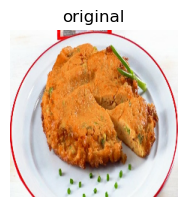

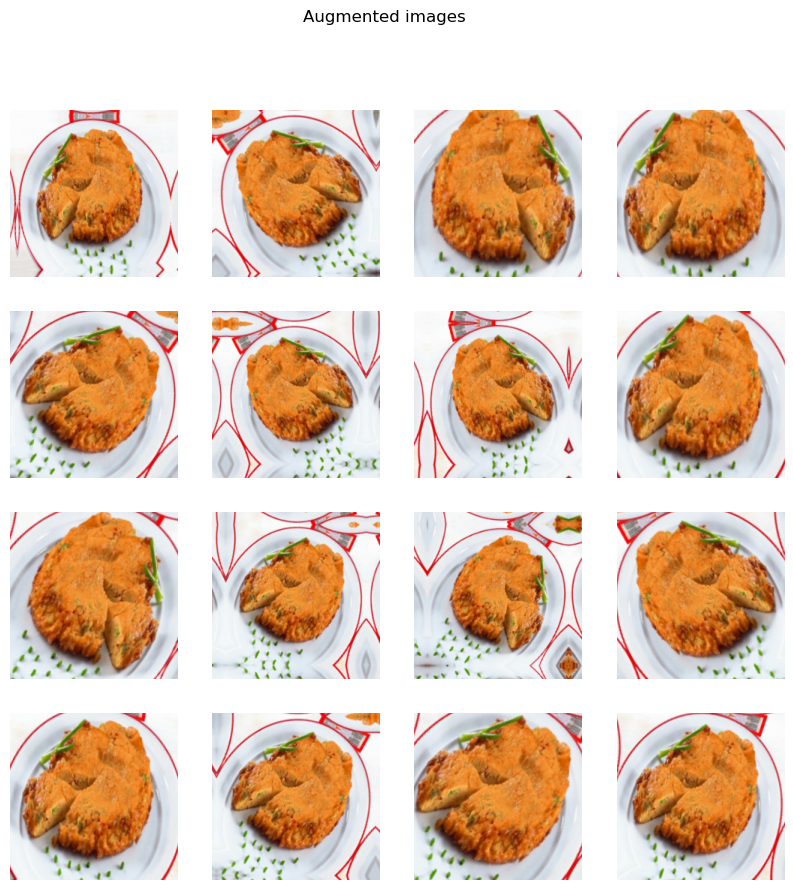

In [21]:
# SHOW A FEW SAMPLES OF IMAGE AUGMENTATION FOR REFERENCE

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    ax = plt.subplot(441)
    ax.imshow(images[0].numpy().astype('uint8'))
    ax.set_title('original')
    ax.axis('off')

    fig = plt.figure(figsize=(10, 10))
    for i in range(16):
        augmented_image = data_augmentation(images[0], training=True) # training must be set to True
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(augmented_image.numpy().astype('uint8'))
        ax.axis('off')
    fig.suptitle('Augmented images')
    plt.show()

# 7. Building Models

# 7.1 Define Augmentation Layer

In [34]:
# Define augmentation layer
augmentation_layer = Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation((-0.1, 0.1)),
     layers.RandomZoom((-0.2, 0.2))
    ]
)

# 7. 2 Use Base CNN Model

In [59]:
basemodel = Sequential()
basemodel.add(Input(shape=(224,224,3)))
basemodel.add(augmentation_layer)

for size in [32, 64, 128, 512]:
    basemodel.add(layers.Conv2D(size, 3, padding='same', activation='relu'))
    basemodel.add(layers.BatchNormalization())
    basemodel.add(layers.MaxPooling2D(pool_size=2))

    

In [60]:
# FULLY CONNECTED LAYER

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(512, activation='relu'))
basemodel.add(Dropout(0.4))

basemodel.add(layers.Dense(9, activation='softmax'))

In [61]:
basemodel.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, None, None, None)  0         
                                                                 
 conv2d_98 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_98 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_99 (Bat  (None, 112, 112, 64)   

# 7.3 Use transfer learning VGG16

In [80]:
vgg16layer = VGG16(
    weights='imagenet', 
    include_top=False, 
)
vgg16layer.trainable = False

In [81]:
vgg16model = keras.Sequential()
vgg16model.add(Input(shape=(224,224,3)))
vgg16model.add(augmentation_layer)
vgg16model.add(vgg16layer)
vgg16model.add(layers.Flatten())
vgg16model.add(layers.Dense(512, activation='relu'))
vgg16model.add(Dropout(0.5))
vgg16model.add(layers.Dense(9, activation='softmax'))

In [82]:
vgg16model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, None, None, None)  0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_12 (Flatten)        (None, 25088)             0         
                                                                 
 dense_17 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 9)                 4617      
                                                                 
Total params: 27,564,873
Trainable params: 12,850,185

# 7.4 Use transfer learning  Inception V3

In [89]:
inceptlayer = InceptionV3(
    weights='imagenet', 
    include_top=False, 
)
inceptlayer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [90]:
inceptmodel = keras.Sequential()
inceptmodel.add(Input(shape=(224,224,3)))
inceptmodel.add(augmentation_layer)
inceptmodel.add(inceptlayer)

inceptmodel.add(layers.Flatten())
inceptmodel.add(Dropout(0.4))
inceptmodel.add(layers.Dense(512, activation='relu'))
inceptmodel.add(Dropout(0.2))
inceptmodel.add(layers.Dense(9, activation='softmax'))

In [91]:
inceptmodel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_9 (Dropout)         (None, 51200)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 9)                

# 8. Train Models

In [92]:
#  INTRODUCE CALLBACKS

early_stop = EarlyStopping(patience=4, monitor="val_accuracy")  
#Stop training when a monitored metric has stopped improving


model_chkpt = ModelCheckpoint('save_at_{epoch}.h5')  
#Save the Keras model or model weights at some frequency

callbacks = [
    early_stop,
    model_chkpt
]

#Callback is an object that can perform actions at various stages of training 
#(e.g. at the start or end of an epoch, before or after a single batch, etc).

# 8.1 Training using base CNN

In [62]:
basemodel.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [63]:
base_hist= basemodel.fit(train_image_gen,
                    validation_data = val_image_gen,
                    epochs=200)

Epoch 1/200
22/22 [==============================] - 18s 789ms/step - loss: 2.7903 - accuracy: 0.2938 - val_loss: 2.2231 - val_accuracy: 0.1186
Epoch 2/200
22/22 [==============================] - 17s 779ms/step - loss: 1.9588 - accuracy: 0.4139 - val_loss: 2.3317 - val_accuracy: 0.1186
Epoch 3/200
22/22 [==============================] - 17s 777ms/step - loss: 1.4458 - accuracy: 0.5311 - val_loss: 2.6248 - val_accuracy: 0.1186
Epoch 4/200
22/22 [==============================] - 17s 764ms/step - loss: 1.3613 - accuracy: 0.5007 - val_loss: 3.0284 - val_accuracy: 0.1186
Epoch 5/200
22/22 [==============================] - 17s 779ms/step - loss: 1.3031 - accuracy: 0.5557 - val_loss: 3.4758 - val_accuracy: 0.1186
Epoch 6/200
22/22 [==============================] - 17s 765ms/step - loss: 1.2815 - accuracy: 0.5658 - val_loss: 3.0907 - val_accuracy: 0.1186
Epoch 7/200
22/22 [==============================] - 17s 770ms/step - loss: 1.1949 - accuracy: 0.5543 - val_loss: 3.5235 - val_accuracy:

In [64]:
basemodel.save('basemodel.h5')

# 8.2 Training using VGG16

In [83]:
vgg16model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [84]:
vgg16_hist= vgg16model.fit(train_image_gen,
                    validation_data = val_image_gen,
                    epochs=150)

Epoch 1/150
22/22 [==============================] - 19s 826ms/step - loss: 2.5234 - accuracy: 0.1360 - val_loss: 2.1573 - val_accuracy: 0.1804
Epoch 2/150
22/22 [==============================] - 17s 769ms/step - loss: 2.2219 - accuracy: 0.1766 - val_loss: 2.0073 - val_accuracy: 0.3041
Epoch 3/150
22/22 [==============================] - 17s 794ms/step - loss: 2.1304 - accuracy: 0.2026 - val_loss: 1.9204 - val_accuracy: 0.3093
Epoch 4/150
22/22 [==============================] - 17s 762ms/step - loss: 2.0150 - accuracy: 0.2590 - val_loss: 1.8179 - val_accuracy: 0.4433
Epoch 5/150
22/22 [==============================] - 18s 808ms/step - loss: 1.8847 - accuracy: 0.2952 - val_loss: 1.7541 - val_accuracy: 0.4175
Epoch 6/150
22/22 [==============================] - 17s 766ms/step - loss: 1.7958 - accuracy: 0.3343 - val_loss: 1.6899 - val_accuracy: 0.4948
Epoch 7/150
22/22 [==============================] - 17s 802ms/step - loss: 1.7229 - accuracy: 0.3864 - val_loss: 1.6021 - val_accuracy:

In [85]:

vgg16model.save('vgg16emodel2_Aug.h5')

# 8.3 Training using InceptionV3

In [93]:
inceptmodel.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [94]:

incept_hist= inceptmodel.fit(train_image_gen,
                    validation_data = val_image_gen,
                    epochs=150)

Epoch 1/150
22/22 [==============================] - 24s 884ms/step - loss: 7.6780 - accuracy: 0.2721 - val_loss: 1.4137 - val_accuracy: 0.5052
Epoch 2/150
22/22 [==============================] - 17s 759ms/step - loss: 1.5364 - accuracy: 0.5441 - val_loss: 0.9459 - val_accuracy: 0.7010
Epoch 3/150
22/22 [==============================] - 17s 797ms/step - loss: 1.1342 - accuracy: 0.6295 - val_loss: 0.8403 - val_accuracy: 0.6959
Epoch 4/150
22/22 [==============================] - 17s 758ms/step - loss: 1.1823 - accuracy: 0.6541 - val_loss: 1.0777 - val_accuracy: 0.6392
Epoch 5/150
22/22 [==============================] - 17s 788ms/step - loss: 0.8102 - accuracy: 0.7279 - val_loss: 0.7022 - val_accuracy: 0.7732
Epoch 6/150
22/22 [==============================] - 17s 778ms/step - loss: 0.9093 - accuracy: 0.7149 - val_loss: 0.6757 - val_accuracy: 0.7990
Epoch 7/150
22/22 [==============================] - 17s 789ms/step - loss: 0.8210 - accuracy: 0.7410 - val_loss: 0.6142 - val_accuracy:

In [95]:
inceptmodel.save('inceptmodel2.h5')

# 9. Training Results

# 9.1 Result Of Base Model

In [65]:
#OUTPUT RESULTS OF BASE MODEL

basemodel_df = pd.DataFrame.from_dict(base_hist.history)
print(basemodel_df.head())
print(basemodel_df.tail())

# Accuracy compute the frequency with which y_pred matches y_true. This frequency is ultimately returned as binary accuracy: an idempotent operation that simply divides total by count.
# The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model. The goal is generally to get your model as close to 0 as possible
# Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events

       loss  accuracy  val_loss  val_accuracy
0  2.790328  0.293777  2.223126      0.118557
1  1.958793  0.413893  2.331659      0.118557
2  1.445780  0.531114  2.624800      0.118557
3  1.361261  0.500724  3.028373      0.118557
4  1.303084  0.555716  3.475816      0.118557
         loss  accuracy  val_loss  val_accuracy
195  0.107206  0.962373  1.445981      0.706186
196  0.134941  0.959479  1.326726      0.690722
197  0.119206  0.955137  1.565452      0.675258
198  0.119108  0.959479  1.401018      0.670103
199  0.101705  0.965268  1.463274      0.716495


# 9.2 Result of VGG16

In [66]:
#OUTPUT RESULTS OF TRANSFER LEARNING VGG16

vgg16model_df = pd.DataFrame.from_dict(vgg16_hist.history)
print(vgg16model_df.head())
print(vgg16model_df.tail())

# Having a low accuracy but a high loss would mean that the model makes big errors in most of the data. But, if both loss and accuracy are low, it means the model makes small errors in most of the data. However, if they’re both high, it makes big errors in some of the data. Finally, if the accuracy is high and the loss is low, then the model makes small errors on just some of the data, which would be the ideal case.
# https://www.baeldung.com/cs/ml-loss-accuracy

       loss  accuracy  val_loss  val_accuracy
0  2.443327  0.134588  2.073171      0.221649
1  2.213248  0.175109  1.960582      0.304124
2  2.069115  0.248915  1.800745      0.453608
3  1.908881  0.289436  1.718157      0.479381
4  1.750447  0.371925  1.635664      0.530928
         loss  accuracy  val_loss  val_accuracy
145  0.145084  0.979739  0.579002      0.809278
146  0.130604  0.972504  0.603790      0.804124
147  0.139428  0.978292  0.645681      0.809278
148  0.139787  0.975398  0.600230      0.798969
149  0.127988  0.981187  0.574153      0.798969


# 9.3 Result of InceptionV3

In [67]:
#OUTPUT RESULTS OF TRANSFER LEARNING - INCEPT

inceptmodel_df = pd.DataFrame.from_dict(incept_hist.history)
print(inceptmodel_df.head())
print(inceptmodel_df.tail())

       loss  accuracy  val_loss  val_accuracy
0  6.724218  0.277858  2.091126      0.453608
1  1.530343  0.549928  1.150389      0.634021
2  1.108400  0.655572  0.687930      0.752577
3  1.052032  0.662808  1.000058      0.690722
4  0.948449  0.701881  0.805055      0.731959
         loss  accuracy  val_loss  val_accuracy
145  0.090668  0.978292  0.670317      0.871134
146  0.096691  0.972504  0.733966      0.881443
147  0.096040  0.973951  0.951549      0.829897
148  0.169514  0.960926  0.824295      0.871134
149  0.122255  0.966715  0.853243      0.829897


# 10. Loss and Accuracy Curves

# 10.1 Loss and Accuracy Curves for Base and VGG16 

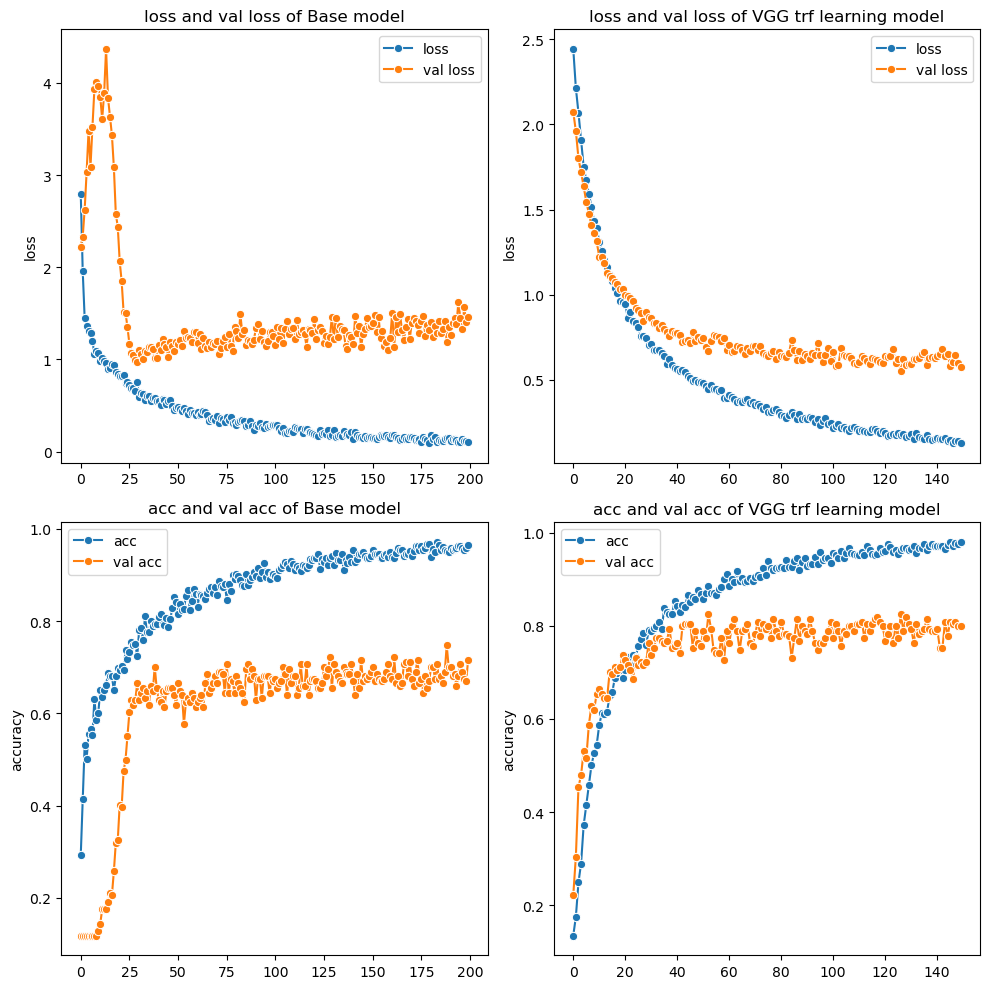

In [68]:
# DISPLAY RESULTS FOR BASE AND VGG 

plt.figure(figsize=(10, 10))
plt.subplot(221)
sns.lineplot(x=basemodel_df.index, y='loss', data=basemodel_df, label='loss',marker = 'o')
sns.lineplot(x=basemodel_df.index, y='val_loss', data=basemodel_df, label='val loss',marker = 'o')
plt.title('loss and val loss of Base model')

plt.subplot(222)
sns.lineplot(x=vgg16model_df.index, y='loss', data=vgg16model_df, label='loss',marker = 'o')
sns.lineplot(x=vgg16model_df.index, y='val_loss', data=vgg16model_df, label ='val loss',marker = 'o')
plt.title('loss and val loss of VGG trf learning model')


plt.subplot(223)
sns.lineplot(x=basemodel_df.index, y='accuracy', data=basemodel_df, label='acc',marker = 'o')
sns.lineplot(x=basemodel_df.index, y='val_accuracy', data=basemodel_df, label='val acc',marker = 'o')
plt.title('acc and val acc of Base model')

plt.subplot(224)
sns.lineplot(x=vgg16model_df.index, y='accuracy', data=vgg16model_df, label='acc',marker = 'o')
sns.lineplot(x=vgg16model_df.index, y='val_accuracy', data=vgg16model_df, label='val acc',marker = 'o')
plt.title('acc and val acc of VGG trf learning model')

plt.tight_layout()
plt.show()

# 10.2 Loss and Accuracy Curve for InceptionV3

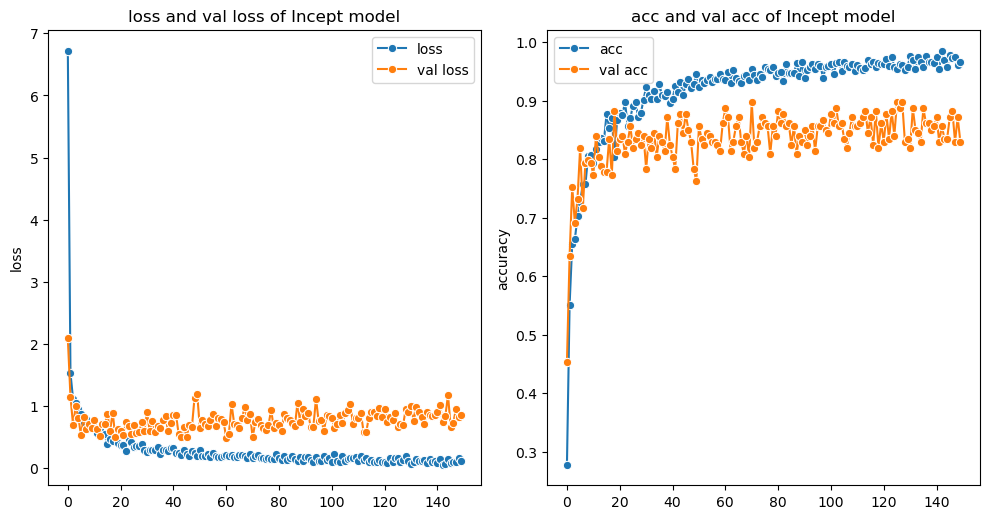

In [70]:
# DISPLAY RESULTS FOR INCEPTION V3 

plt.figure(figsize=(10, 10))
plt.subplot(221)
sns.lineplot(x=inceptmodel_df.index, y='loss', data=inceptmodel_df, label='loss',marker = 'o')
sns.lineplot(x=inceptmodel_df.index, y='val_loss', data=inceptmodel_df, label='val loss',marker = 'o')
plt.title('loss and val loss of Incept model')



plt.subplot(222)
sns.lineplot(x=inceptmodel_df.index, y='accuracy', data=inceptmodel_df, label='acc',marker = 'o')
sns.lineplot(x=inceptmodel_df.index, y='val_accuracy', data=inceptmodel_df, label='val acc',marker = 'o')
plt.title('acc and val acc of Incept model')


plt.tight_layout()
plt.show()

# 11. Evaluate Models with Test Dataset

In [3]:
# 11.1 EVALUATE BASE MODEL

scorebase = basemodel.evaluate(test_image_gen)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(scorebase))

#print(basemodel.metrics_names)

NameError: name 'basemodel' is not defined

In [75]:
# 11.2 EVALUATE VGG16

scorevgg16 = vgg16model.evaluate(test_image_gen)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(scorevgg16))

#print(basemodel.metrics_names)

4/4 [==============================] - 2s 559ms/step - loss: 0.4925 - accuracy: 0.7870

Test loss: 0.492543, Test accuracy: 0.787037


In [77]:
# 11.3 EVALUATE INCEPTION V3

scoreincept = inceptmodel.evaluate(test_image_gen)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(scoreincept))

#print(basemodel.metrics_names)

4/4 [==============================] - 2s 532ms/step - loss: 0.9096 - accuracy: 0.8611

Test loss: 0.909565, Test accuracy: 0.861111


# 12. Using InceptionV3 for prediction

In [78]:
predictions = np.argmax(inceptmodel.predict(test_image_gen), axis = -1)
predictions
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_image_gen.classes,predictions,target_names=['ayam_goreng', 'ayam_pop', 'daging_rendang', 'dendeng_batokok', 'gulai_ikan', 'gulai_tambusu', 'gulai_tunjang', 'telur_balado', 'telur_dadar']))

4/4 [==============================] - 3s 446ms/step
                 precision    recall  f1-score   support

    ayam_goreng       0.85      0.92      0.88        12
       ayam_pop       1.00      0.92      0.96        12
 daging_rendang       0.91      0.83      0.87        12
dendeng_batokok       0.92      0.92      0.92        12
     gulai_ikan       0.83      0.42      0.56        12
  gulai_tambusu       0.90      0.82      0.86        11
  gulai_tunjang       0.57      0.92      0.71        13
   telur_balado       0.83      0.83      0.83        12
    telur_dadar       1.00      1.00      1.00        12

       accuracy                           0.84       108
      macro avg       0.87      0.84      0.84       108
   weighted avg       0.86      0.84      0.84       108



# 13. Confusion Matrix

Confusion matrix


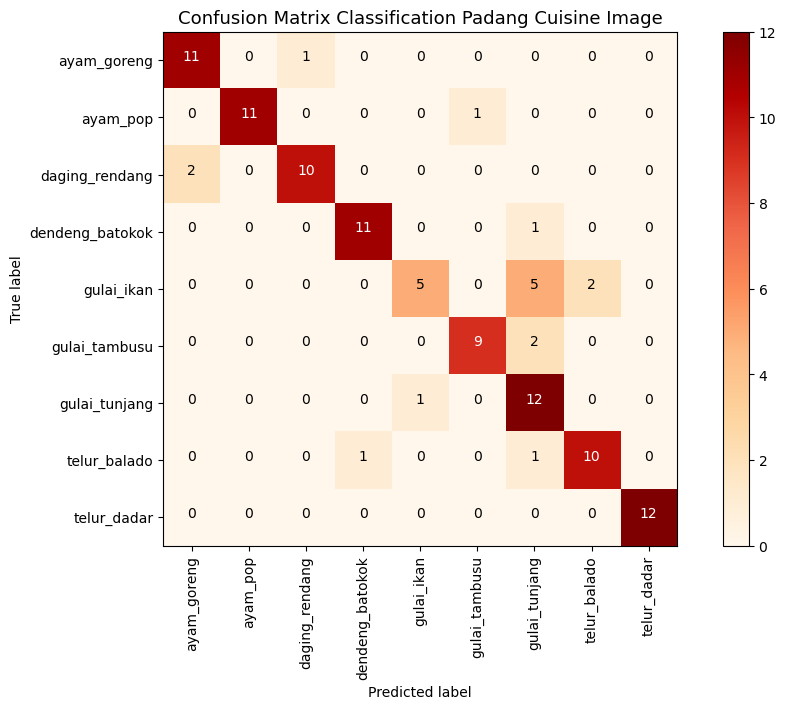

In [79]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix Classification Padang Cuisine Image',
                          cmap=plt.cm.OrRd):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    #print(cm)
    plt.rcParams['figure.figsize'] = (10.0, 7.0)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 13)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix=confusion_matrix(test_image_gen.classes,predictions)
plot_confusion_matrix(cnf_matrix, classes=test_image_gen.class_indices)